In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import sys
import scipy 
from scipy.stats import ortho_group
import pdb
import tqdm
import matplotlib.pyplot as plt
from glob import glob
import importlib

In [3]:
from statsmodels import tsa
import pylds
from pylds.models import DefaultLDS
import pykalman

ModuleNotFoundError: No module named 'pylds'

In [3]:
sys.path.append('../..')

In [4]:
from neurosim.models.ssr import StateSpaceRealization as SSR
from subspaces import estimate_autocorrelation, SubspaceIdentification, IteratedStableEstimator

### Statsmodels Test

In [6]:
# Test the statsmodels state space inference and how long it takes to do the inference

In [7]:
size = 20
A = 1/(np.sqrt(size)) * np.random.normal(size=(size, size))
while max(np.abs(np.linalg.eigvals(A)) > 0.99):
    A = 1/(np.sqrt(size)) * np.random.normal(size=(size, size))

ssr = SSR(A = A, B=ortho_group.rvs(size)[:, 0:4], C = np.eye(A.shape[0]))

In [8]:
x = ssr.trajectory(int(1e4))

In [11]:
x.shape

(10001, 20)

In [37]:
D_obs = size
D_latent = size
D_input = 0
model = DefaultLDS(D_obs, D_latent, D_input)

In [38]:
model.add_data(x)

In [39]:
def update(model):
    model.EM_step()
    return model.log_likelihood()

In [60]:
lls = [update(model) for _ in tqdm.tqdm(range(100))]

/home/akumar/nse/pylds/pylds/states.py:326: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  [E_xtp1_xtp1T, E_xtp1_xutT, E_xut_xutT, self.T - 1])
/home/akumar/nse/pybasicbayes/pybasicbayes/distributions/regression.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([A,B,C,d])
100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


Text(0, 0.5, 'training likelihood')

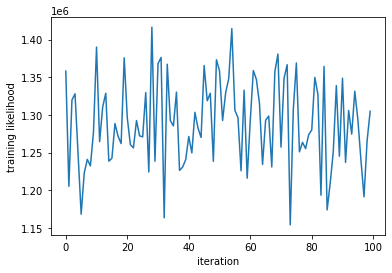

In [61]:
# Plot the log likelihoods
plt.figure()
plt.plot(lls)
plt.xlabel('iteration')
plt.ylabel('training likelihood')

In [69]:
model.sigma_states

array([[ 5.79544783e-02, -3.11819298e-02, -2.06900924e-03,
        -4.44290535e-02, -1.48731982e-02,  1.87174309e-02,
         2.28887694e-02,  2.86551428e-02, -4.79393721e-03,
        -1.29690009e-03, -1.72497275e-02,  4.29097208e-02,
        -1.05905766e-02, -2.03587368e-02, -3.43323656e-02,
        -1.97753368e-02, -2.19837847e-02,  8.65235471e-03,
        -1.03052311e-02, -1.13259086e-02],
       [-3.11819298e-02,  2.71722820e-02,  4.46753815e-03,
         1.93586867e-02,  4.40814581e-03, -2.10820113e-02,
        -6.31038297e-03, -4.30842825e-03,  5.21107503e-03,
         7.16332793e-03,  8.88197764e-03, -1.92729346e-02,
         2.12858781e-02,  4.92599806e-03,  2.49815928e-02,
         1.95659080e-03,  1.79462860e-02,  5.30688965e-03,
         1.10323735e-02,  1.97103325e-02],
       [-2.06900924e-03,  4.46753815e-03,  6.76960710e-03,
         9.26573049e-04, -2.82446508e-03,  9.44202362e-04,
        -1.86006108e-03, -3.05048159e-03, -4.35248274e-03,
         1.85267033e-03, -6.3

In [42]:
kf = pykalman.KalmanFilter(n_dim_state=size, n_dim_obs=size,
    em_vars=[
      'transition_matrices', 'observation_matrices',
      'transition_covariance', 'observation_covariance',
      'observation_offsets', 'initial_state_mean',
      'initial_state_covariance'
    ]
)

In [52]:
from pykalman.datasets import load_robot

In [54]:
data = load_robot()

FileNotFoundError: [Errno 2] No such file or directory: '/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/pykalman/datasets/descr/robot.rst'

In [45]:
ll = np.zeros(20)
for i in range(ll.size):
    kf.em(x, n_iter=1)
    ll[i] = kf.loglikelihood(x)

ValueError: masked arrays are not supported

### CC coefs on Sabes

In [70]:
# On neural data, do (1) subspace identification, (2) LDS fitting, and evaluate (1) gMDL/BIC/AIC vs. UoILasso and consistency of subspaces

In [10]:
sys.path.append('/home/akumar/nse/neural_control/submit_files')
sys.path.append('/home/akumar/nse/neural_control')

In [11]:
from loaders import load_sabes
from pyuoi.linear_model.var import VAR
from dca.dca import DynamicalComponentsAnalysis as DCA
from dca.cov_util import calc_cross_cov_mats_from_data
from neurosim.utils.symbols import gen_hankel_from_blocks, gen_toeplitz_from_blocks
from sklearn.decomposition import PCA

In [9]:

data_files = glob('/mnt/Secondary/data/sabes/*.mat')
# Use a fixed set of preprocessing/decoding parameters
sabes_args = importlib.import_module('sabes_dimreduc_args')

In [11]:
cc_coefs = []
for i, data_file in tqdm.tqdm(enumerate(data_files)):
    dat = load_sabes(data_file, **sabes_args.loader_args[0])
    X = np.squeeze(dat['spike_rates'])
    ccm = calc_cross_cov_mats_from_data(X, 11)
    order = 3

    # Choose model order using hankel singular values
    H = gen_hankel_from_blocks(ccm, order1=order, order2=order)
    sigmaH = gen_hankel_from_blocks(ccm, order1=order, order2=order, shift=1)

    Tm, Tp = gen_toeplitz_from_blocks(ccm, order=order)
    Lm = np.linalg.cholesky(Tm)
    Lp = np.linalg.cholesky(Tp)

    # Normalized Hankel matrices
    Hnorm = np.linalg.inv(Lp) @ H @ np.linalg.inv(Lm).T
    sigmaHnorm = np.linalg.inv(Lp) @ sigmaH @ np.linalg.inv(Lm).T

    # SVD
    Ut, St, Vht = np.linalg.svd(Hnorm)    
    cc_coefs.append(St)

0it [00:00, ?it/s]

Processing spikes


100%|██████████| 1/1 [00:16<00:00, 16.32s/it]
1it [00:17, 17.69s/it]

Processing spikes


100%|██████████| 1/1 [00:22<00:00, 22.95s/it]
2it [00:42, 21.75s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.78s/it]
3it [00:47, 14.24s/it]

Processing spikes


100%|██████████| 1/1 [00:31<00:00, 31.63s/it]
4it [01:20, 21.74s/it]

Processing spikes


100%|██████████| 1/1 [00:13<00:00, 13.83s/it]
5it [01:35, 19.08s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.57s/it]
6it [01:39, 13.93s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.40s/it]
7it [01:42, 10.62s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.39s/it]
8it [01:47,  8.77s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]
9it [01:51,  7.36s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.50s/it]
10it [01:55,  6.27s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.68s/it]
11it [02:01,  5.94s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.56s/it]
12it [02:05,  5.64s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.24s/it]
13it [02:12,  6.00s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.79s/it]
14it [02:18,  5.77s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.80s/it]
15it [02:23,  5.62s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.71s/it]
16it [02:28,  5.47s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.42s/it]
17it [02:33,  5.28s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.75s/it]
18it [02:38,  5.25s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.69s/it]
19it [02:43,  5.20s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.42s/it]
20it [02:49,  5.41s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.86s/it]
21it [02:56,  5.99s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.23s/it]
22it [03:01,  5.58s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.21s/it]
23it [03:06,  5.58s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.39s/it]
24it [03:12,  5.62s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.75s/it]
25it [03:18,  5.79s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.53s/it]
26it [03:24,  5.87s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.84s/it]
27it [03:32,  6.34s/it]

Processing spikes


100%|██████████| 1/1 [00:07<00:00,  7.67s/it]
28it [03:40,  7.88s/it]


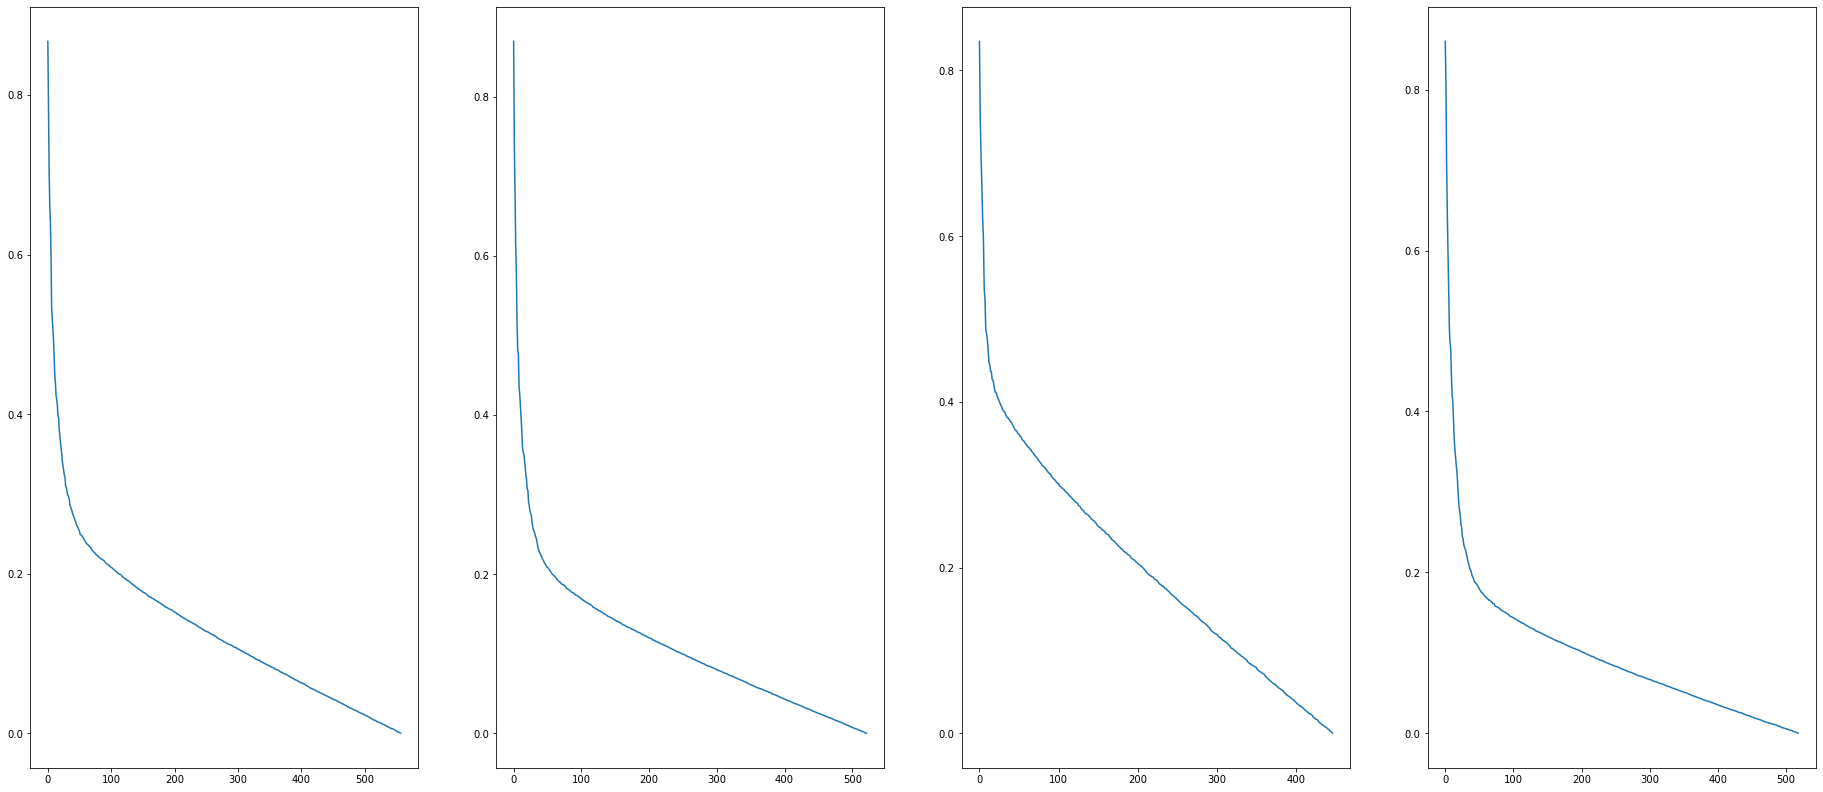

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(32, 14))

for i in range(len(data_files[0:4])):
    a = ax[i]
    a.plot(cc_coefs[i])

In [ ]:
# (1) Analysis that could be done: Selection of model order via MDL - this then identifies the dimension of the state space (we  may need to go to higher order models)
# (2) Use SSID and demonstrate self-consistency of the identified subspaces

### AR order selection

In [18]:
from pyuoi.utils import log_likelihood_glm, gMDL, BIC

In [115]:
order = [1, 2, 3, 4, 5]

In [116]:
BIC_ = np.zeros((len(data_files), len(order)))
gMDL_ = np.zeros((len(data_files), len(order)))

for i, data_file in tqdm.tqdm(enumerate(data_files)):
    dat = load_sabes(data_file, **sabes_args.loader_args[0])
    X = np.squeeze(dat['spike_rates'])
    for j, order_ in enumerate(order):
        varmodel = VAR(estimator='ols', order=order_)
        varmodel.fit(X)

        # Assess gMDL and BIC
        Xpred, Xtrue = varmodel.predict(X)
        ll = log_likelihood_glm('normal', Xtrue, Xpred)
        BIC_[i, j] = BIC(ll, np.product(varmodel.coef_.shape), X.shape[0])
        gMDL_[i, j] = gMDL(Xtrue, Xpred, np.product(varmodel.coef_.shape))

0it [00:00, ?it/s]

Processing spikes


100%|██████████| 1/1 [00:16<00:00, 16.32s/it]
Rows of VAR matrix processed: 186it [00:13, 13.34it/s]
Rows of VAR matrix processed: 186it [00:27,  6.69it/s]
Rows of VAR matrix processed: 186it [00:49,  3.78it/s]
Rows of VAR matrix processed: 186it [01:14,  2.49it/s]
Rows of VAR matrix processed: 186it [01:48,  1.71it/s]
1it [05:05, 305.63s/it]

Processing spikes


100%|██████████| 1/1 [00:22<00:00, 22.77s/it]
Rows of VAR matrix processed: 174it [00:16, 10.53it/s]
Rows of VAR matrix processed: 174it [00:36,  4.76it/s]
Rows of VAR matrix processed: 174it [01:00,  2.89it/s]
Rows of VAR matrix processed: 174it [01:26,  2.02it/s]
Rows of VAR matrix processed: 174it [02:03,  1.41it/s]
2it [11:11, 340.86s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.65s/it]
Rows of VAR matrix processed: 149it [00:01, 93.71it/s]
Rows of VAR matrix processed: 149it [00:04, 33.89it/s]
Rows of VAR matrix processed: 149it [00:07, 18.97it/s]
Rows of VAR matrix processed: 149it [00:12, 12.27it/s]
Rows of VAR matrix processed: 149it [00:19,  7.75it/s]
3it [12:03, 209.34s/it]

Processing spikes


100%|██████████| 1/1 [00:31<00:00, 31.16s/it]
Rows of VAR matrix processed: 173it [00:19,  8.71it/s]
Rows of VAR matrix processed: 173it [00:48,  3.58it/s]
Rows of VAR matrix processed: 173it [01:12,  2.38it/s]
Rows of VAR matrix processed: 173it [02:09,  1.34it/s]
Rows of VAR matrix processed: 173it [03:00,  1.04s/it]
4it [20:30, 326.49s/it]

Processing spikes


100%|██████████| 1/1 [00:13<00:00, 13.61s/it]
Rows of VAR matrix processed: 97it [00:02, 46.18it/s]
Rows of VAR matrix processed: 97it [00:05, 17.73it/s]
Rows of VAR matrix processed: 97it [00:08, 10.96it/s]
Rows of VAR matrix processed: 97it [00:12,  7.48it/s]
Rows of VAR matrix processed: 97it [00:16,  5.80it/s]
5it [21:34, 231.90s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.55s/it]
Rows of VAR matrix processed: 134it [00:01, 108.14it/s]
Rows of VAR matrix processed: 134it [00:03, 44.24it/s]
Rows of VAR matrix processed: 134it [00:05, 25.11it/s]
Rows of VAR matrix processed: 134it [00:07, 18.11it/s]
Rows of VAR matrix processed: 134it [00:12, 10.64it/s]
6it [22:09, 165.04s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.35s/it]
Rows of VAR matrix processed: 133it [00:00, 137.99it/s]
Rows of VAR matrix processed: 133it [00:02, 51.03it/s]
Rows of VAR matrix processed: 133it [00:04, 28.56it/s]
Rows of VAR matrix processed: 133it [00:07, 18.58it/s]
Rows of VAR matrix processed: 133it [00:13,  9.79it/s]
7it [22:43, 122.31s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.22s/it]
Rows of VAR matrix processed: 142it [00:01, 92.09it/s] 
Rows of VAR matrix processed: 142it [00:04, 35.15it/s]
Rows of VAR matrix processed: 142it [00:06, 20.36it/s]
Rows of VAR matrix processed: 142it [00:10, 13.15it/s]
Rows of VAR matrix processed: 142it [00:16,  8.54it/s]
8it [23:30, 98.28s/it] 

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]
Rows of VAR matrix processed: 138it [00:01, 107.63it/s]
Rows of VAR matrix processed: 138it [00:03, 39.37it/s]
Rows of VAR matrix processed: 138it [00:06, 21.32it/s]
Rows of VAR matrix processed: 138it [00:08, 15.38it/s]
Rows of VAR matrix processed: 138it [00:15,  9.02it/s]
9it [24:12, 80.59s/it]

Processing spikes


100%|██████████| 1/1 [00:03<00:00,  3.49s/it]
Rows of VAR matrix processed: 122it [00:00, 143.00it/s]
Rows of VAR matrix processed: 122it [00:02, 55.27it/s]
Rows of VAR matrix processed: 122it [00:04, 29.57it/s]
Rows of VAR matrix processed: 122it [00:05, 22.51it/s]
Rows of VAR matrix processed: 122it [00:08, 14.81it/s]
10it [24:38, 63.77s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.59s/it]
Rows of VAR matrix processed: 141it [00:01, 92.00it/s]
Rows of VAR matrix processed: 141it [00:04, 35.21it/s]
Rows of VAR matrix processed: 141it [00:07, 19.75it/s]
Rows of VAR matrix processed: 141it [00:10, 14.00it/s]
Rows of VAR matrix processed: 141it [00:16,  8.37it/s]
11it [25:25, 58.62s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.50s/it]
Rows of VAR matrix processed: 137it [00:01, 106.56it/s]
Rows of VAR matrix processed: 137it [00:03, 37.18it/s]
Rows of VAR matrix processed: 137it [00:06, 21.75it/s]
Rows of VAR matrix processed: 137it [00:09, 14.93it/s]
Rows of VAR matrix processed: 137it [00:15,  9.04it/s]
12it [26:08, 53.78s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.22s/it]
Rows of VAR matrix processed: 152it [00:02, 62.59it/s]
Rows of VAR matrix processed: 152it [00:06, 23.76it/s]
Rows of VAR matrix processed: 152it [00:10, 14.07it/s]
Rows of VAR matrix processed: 152it [00:15,  9.99it/s]
Rows of VAR matrix processed: 152it [00:26,  5.77it/s]
13it [27:19, 59.18s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.74s/it]
Rows of VAR matrix processed: 132it [00:01, 108.65it/s]
Rows of VAR matrix processed: 132it [00:03, 35.31it/s]
Rows of VAR matrix processed: 132it [00:05, 22.21it/s]
Rows of VAR matrix processed: 132it [00:09, 14.57it/s]
Rows of VAR matrix processed: 132it [00:14,  9.07it/s]
14it [28:01, 53.99s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.75s/it]
Rows of VAR matrix processed: 145it [00:01, 95.53it/s]
Rows of VAR matrix processed: 145it [00:04, 33.69it/s]
Rows of VAR matrix processed: 145it [00:07, 19.15it/s]
Rows of VAR matrix processed: 145it [00:11, 12.32it/s]
Rows of VAR matrix processed: 145it [00:18,  7.77it/s]
15it [28:53, 53.27s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.61s/it]
Rows of VAR matrix processed: 129it [00:01, 110.63it/s]
Rows of VAR matrix processed: 129it [00:03, 34.02it/s]
Rows of VAR matrix processed: 129it [00:05, 23.86it/s]
Rows of VAR matrix processed: 129it [00:10, 11.95it/s]
Rows of VAR matrix processed: 129it [00:11, 11.10it/s]
16it [29:33, 49.20s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.33s/it]
Rows of VAR matrix processed: 130it [00:01, 116.89it/s]
Rows of VAR matrix processed: 130it [00:03, 39.73it/s]
Rows of VAR matrix processed: 130it [00:05, 23.63it/s]
Rows of VAR matrix processed: 130it [00:08, 16.15it/s]
Rows of VAR matrix processed: 130it [00:11, 11.40it/s]
17it [30:09, 45.25s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.68s/it]
Rows of VAR matrix processed: 143it [00:01, 95.80it/s]
Rows of VAR matrix processed: 143it [00:04, 34.31it/s]
Rows of VAR matrix processed: 143it [00:07, 20.20it/s]
Rows of VAR matrix processed: 143it [00:10, 13.66it/s]
Rows of VAR matrix processed: 143it [00:17,  8.09it/s]
18it [30:57, 46.22s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.61s/it]
Rows of VAR matrix processed: 129it [00:01, 103.44it/s]
Rows of VAR matrix processed: 129it [00:03, 35.09it/s]
Rows of VAR matrix processed: 129it [00:05, 22.79it/s]
Rows of VAR matrix processed: 129it [00:10, 11.84it/s]
Rows of VAR matrix processed: 129it [00:12, 10.72it/s]
19it [31:38, 44.51s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.35s/it]
Rows of VAR matrix processed: 143it [00:01, 81.18it/s]
Rows of VAR matrix processed: 143it [00:04, 31.61it/s]
Rows of VAR matrix processed: 143it [00:08, 17.75it/s]
Rows of VAR matrix processed: 143it [00:11, 12.67it/s]
Rows of VAR matrix processed: 143it [00:19,  7.39it/s]
20it [32:31, 47.24s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.72s/it]
Rows of VAR matrix processed: 129it [00:01, 68.65it/s]
Rows of VAR matrix processed: 129it [00:05, 24.28it/s]
Rows of VAR matrix processed: 129it [00:08, 15.83it/s]
Rows of VAR matrix processed: 129it [00:15,  8.20it/s]
Rows of VAR matrix processed: 129it [00:16,  7.87it/s]
21it [33:29, 50.37s/it]

Processing spikes


100%|██████████| 1/1 [00:04<00:00,  4.13s/it]
Rows of VAR matrix processed: 129it [00:01, 115.58it/s]
Rows of VAR matrix processed: 129it [00:03, 37.85it/s]
Rows of VAR matrix processed: 129it [00:05, 24.54it/s]
Rows of VAR matrix processed: 129it [00:09, 12.95it/s]
Rows of VAR matrix processed: 129it [00:10, 11.77it/s]
22it [34:06, 46.37s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.11s/it]
Rows of VAR matrix processed: 126it [00:01, 105.91it/s]
Rows of VAR matrix processed: 126it [00:03, 38.05it/s]
Rows of VAR matrix processed: 126it [00:05, 21.41it/s]
Rows of VAR matrix processed: 126it [00:08, 15.63it/s]
Rows of VAR matrix processed: 126it [00:11, 10.80it/s]
23it [34:44, 43.81s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.34s/it]
Rows of VAR matrix processed: 114it [00:01, 111.26it/s]
Rows of VAR matrix processed: 114it [00:02, 41.87it/s]
Rows of VAR matrix processed: 114it [00:04, 23.28it/s]
Rows of VAR matrix processed: 114it [00:06, 16.89it/s]
Rows of VAR matrix processed: 114it [00:09, 11.78it/s]
24it [35:16, 40.47s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.66s/it]
Rows of VAR matrix processed: 124it [00:01, 92.17it/s]
Rows of VAR matrix processed: 124it [00:03, 33.27it/s]
Rows of VAR matrix processed: 124it [00:05, 21.52it/s]
Rows of VAR matrix processed: 124it [00:08, 15.17it/s]
Rows of VAR matrix processed: 124it [00:12, 10.07it/s]
25it [35:56, 40.25s/it]

Processing spikes


100%|██████████| 1/1 [00:05<00:00,  5.47s/it]
Rows of VAR matrix processed: 138it [00:01, 76.07it/s]
Rows of VAR matrix processed: 138it [00:04, 32.19it/s]
Rows of VAR matrix processed: 138it [00:07, 17.70it/s]
Rows of VAR matrix processed: 138it [00:10, 13.08it/s]
Rows of VAR matrix processed: 138it [00:18,  7.41it/s]
26it [36:48, 43.67s/it]

Processing spikes


100%|██████████| 1/1 [00:06<00:00,  6.82s/it]
Rows of VAR matrix processed: 147it [00:02, 57.68it/s]
Rows of VAR matrix processed: 147it [00:06, 22.67it/s]
Rows of VAR matrix processed: 147it [00:10, 13.95it/s]
Rows of VAR matrix processed: 147it [00:15,  9.48it/s]
Rows of VAR matrix processed: 147it [00:25,  5.86it/s]
27it [37:59, 51.96s/it]

Processing spikes


100%|██████████| 1/1 [00:07<00:00,  7.55s/it]
Rows of VAR matrix processed: 138it [00:02, 53.72it/s]
Rows of VAR matrix processed: 138it [00:06, 22.37it/s]
Rows of VAR matrix processed: 138it [00:10, 12.63it/s]
Rows of VAR matrix processed: 138it [00:16,  8.53it/s]
Rows of VAR matrix processed: 138it [00:24,  5.67it/s]
28it [39:11, 83.99s/it]


In [118]:
import pickle

In [119]:
with open('sabes_IC.dat', 'wb') as f:
    f.write(pickle.dumps(BIC_))
    f.write(pickle.dumps(gMDL))
    f.write(pickle.dumps(data_files))

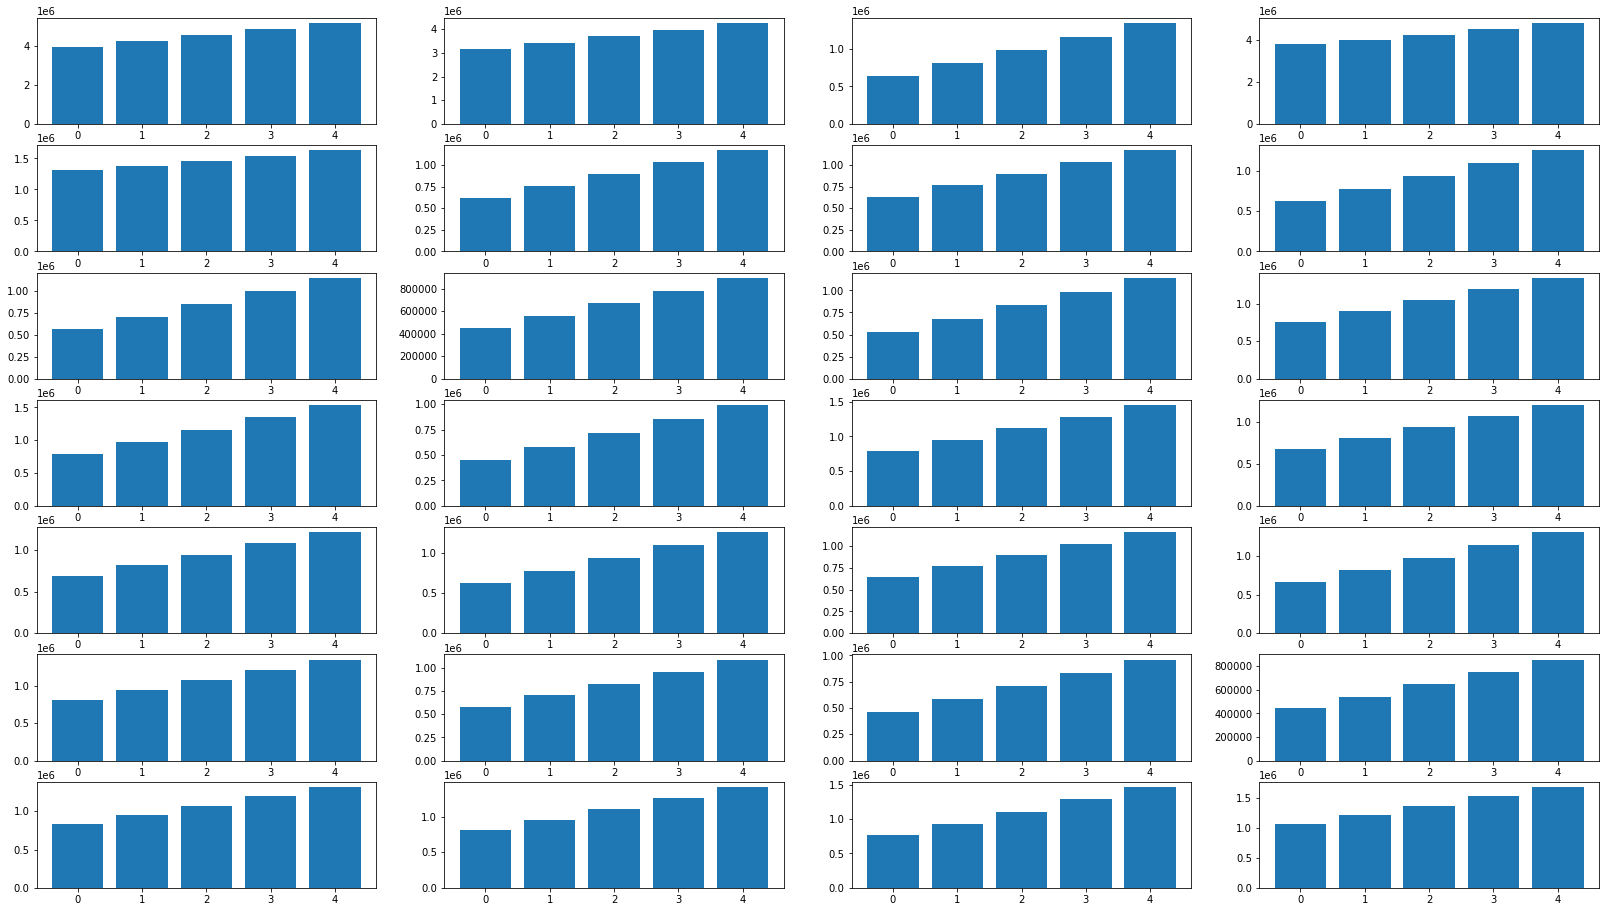

In [124]:
fig, ax = plt.subplots(7, 4, figsize=(28, 16))
for i in range(len(data_files)):

    a = ax[np.unravel_index(i, (7, 4))]
    a.bar(np.arange(len(order)), BIC_[i, :])

In [130]:
np.argmax(-1*gMDL_, axis=1)

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

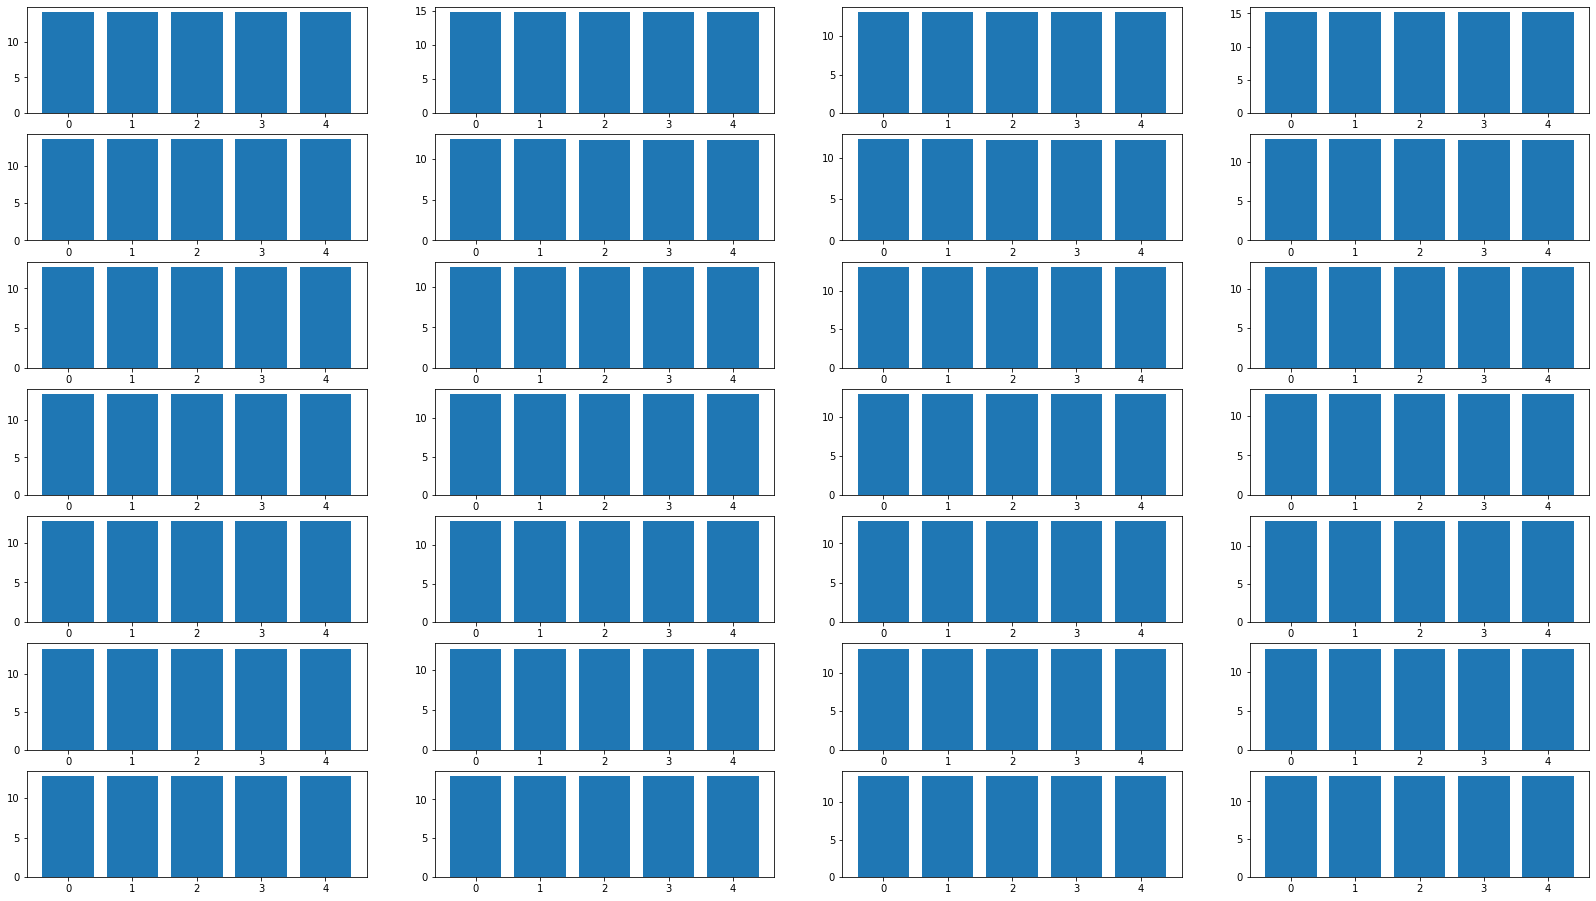

In [127]:
fig, ax = plt.subplots(7, 4, figsize=(28, 16))
for i in range(len(data_files)):

    a = ax[np.unravel_index(i, (7, 4))]
    a.bar(np.arange(len(order)), np.log(-1*gMDL_[i, :]))

### Autocorrelation Tapering


In [ ]:
from cov_estimation import estimate_autocorrelation

In [ ]:
reps = 20
sample_sizes = [int(1e3), int(5e3), int(1e4), int(5e4), int(1e5)]
M = [2, 4, 8]
# Fix the system and calculate across indepndent trajectory presentations
size = 100
A = np.random.normal(scale=1/(2 * np.sqrt(size)), size=(size, size))
while max(np.abs(np.linalg.eigvals(A))) > 0.99:
    A = np.random.normal(scale=1/(2 * np.sqrt(size)), size=(size, size))

C = scipy.stats.ortho_group.rvs(size)[:, 0:20].T
ssr = SSR(A = A, B=np.eye(A.shape[0]), C=C, D=1e-2 * np.random.normal(size=(C.shape[0], A.shape[0])))

T = 20
true_ccm = ssr.autocorrelation(T)

sample_error = np.zeros((len(sample_sizes), len(M), reps, 3, T))
tapered_error = np.zeros((len(sample_sizes), len(M), reps, 3, T))

for i, sample_size in tqdm.tqdm(enumerate(sample_sizes)):
    for j, M_ in tqdm.tqdm(enumerate(M)):
        for k in range(reps):
            y = ssr.trajectory(sample_size)
            sample_ccm = calc_cross_cov_mats_from_data(y, T)
            tapered_ccm = estimate_autocorrelation(y, T)
            
            sample_error[i, j, k, ...] = synthetic_assesment(true_ccm, sample_ccm, T)
            tapered_error[i, j, k, ...] = synthetic_assesment(true_ccm, tapered_ccm, T)

In [ ]:
# Assess sample vs. tapered errors
plt.plot(np.mean(sample_error[:, 0, :, 2, 10], axis=-1))
plt.plot(np.mean(tapered_error[:, 2, :, 2, 10], axis=-1))
import numpy as np
V = np.zeros((10, 2))
np.sum(V, axis=1)

### Subspace Identification

In [6]:
# Given selected model orders, apply state space identification. Show lack of stabilit

In [7]:
# Sweep over state space dimension and evaluate self-consistency of subspaces (stick to just PCA). Do this analysis with and without covariance tapering

In [44]:
from sklearn.linear_model import LinearRegression
from subspaces import SubspaceIdentification, gen_toeplitz_from_blocks, flip_blocks, gen_hankel_from_blocks
from cov_estimation import estimate_autocorrelation 
from utils import calc_loadings
from dca.cov_util import calc_cross_cov_mats_from_data, form_lag_matrix
from pyuoi.linear_model.var import VAR
from neurosim.models.var import VAR as VARss
from tqdm import tqdm

In [13]:
# Assess consistency of SSID in a synthetic system

In [78]:
size = 20
A = np.random.normal(scale=1/(2 * np.sqrt(size)), size=(size, size))
while max(np.abs(np.linalg.eigvals(A))) > 0.99:
    A = np.random.normal(scale=1/(2 * np.sqrt(size)), size=(size, size))

C = scipy.stats.ortho_group.rvs(size)[:, 0:2].T

In [79]:
ssr = SSR(A=A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))
#ssr = SSR(A=A, B=np.eye(A.shape[0]), C=C)

In [80]:
y = ssr.trajectory(int(1e6))

In [81]:
ccm0 = ssr.autocorrelation(10)

In [82]:
ccm = estimate_autocorrelation(y, 10)

In [21]:
x = np.arange(100)[:, np.newaxis]

In [26]:
xp = form_lag_matrix(x, 4).T
xm = flip_blocks(xp, 4)

In [51]:
x[1:-T+1]

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54],
       [55],
       [56],
       [57],
       [58],
       [59],
       [60],
       [61],
       [62],
       [63],
       [64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70],
       [71],
       [72],
       [73],
       [74],
       [75],
       [76],
       [77],

In [49]:
xp[:, -1]

array([96., 97., 98., 99.])

In [45]:
xp[:, 0]

array([0., 1., 2., 3.])

In [19]:
# When is truncating the t + 1 Cholesky factorization equivalent to the Cholesky factorization of the Toeplitz matrix of order t?

In [68]:
def synthetic_assesment(ccm_true, ccm_estimated, ccm_order):
    
    delta_1 = [np.linalg.norm(ccm_true[j] - ccm_estimated[j]) for j in range(ccm_order)]
    delta_2 = [np.linalg.norm(ccm_true[j] - ccm_estimated[j], 'nuc') for j in range(ccm_order)]
    delta_3 = [np.linalg.norm(ccm_true[j] - ccm_estimated[j], np.inf) for j in range(ccm_order)]

    return delta_1, delta_2, delta_3

In [15]:
S = lambda m, t: np.block([[np.zeros((m, m * t))], [np.eye(m * t)]])
E = lambda m, t: np.block([[np.eye(m), np.zeros((m, m * (t - 1)))]]).T

In [16]:
T = 3
N = int(1e6 - 100)

In [95]:
def subspace_identification(y, ccm, order, cc_threshold=1e-12):
    y-= np.mean(y, axis=0)
    m = y.shape[1]
    H = gen_hankel_from_blocks(ccm, order1=order, order2=order)
    sigmaH = gen_hankel_from_blocks(ccm, order1=order, order2=order, shift=1)

    Tm, Tp = gen_toeplitz_from_blocks(ccm, order=order)
    Lm = np.linalg.cholesky(Tm)
    Lp = np.linalg.cholesky(Tp)

    # Normalized Hankel matrices
    Hnorm = np.linalg.inv(Lp) @ H @ np.linalg.inv(Lm).T
    sigmaHnorm = np.linalg.inv(Lp) @ sigmaH @ np.linalg.inv(Lm).T

    # SVD
    Ut, St, Vht = np.linalg.svd(Hnorm)
    # Balanced truncation
    if cc_threshold < 1:
        St = np.diag(St > cc_threshold)
    else:
        St = np.diag(St[0:cc_threshold])
    Ut = Ut[:, 0:St.shape[0]]
    Vht = Vht[0:St.shape[0], :]
    
    # T + 1 quantities, and then we truncate
    Tm1, Tp1 = gen_toeplitz_from_blocks(ccm, order=order + 1)
    Lm1 = np.linalg.cholesky(Tm1)
    Lp1 = np.linalg.cholesky(Tp1)

    H1 = gen_hankel_from_blocks(ccm, order1=order + 1, order2=order + 1)
    H1norm = np.linalg.inv(Lp1) @ H1 @ np.linalg.inv(Lm1).T
    Ut1, St1, Vht1 = np.linalg.svd(H1norm)

    St1 = np.diag(St1[0:St.shape[0]])
    Ut1 = Ut1[:, 0:St.shape[0]]
    Vht1 = Vht1[0:St.shape[0], :]

    Sigmat1 = Lp1 @ Ut1 @ scipy.linalg.sqrtm(St1)
    Sigmabart1 = Lm1 @ Vht1.T @ scipy.linalg.sqrtm(St1) 
    
    Sigmat = Sigmat1[:-m, :] 
    Sigmabart = Sigmabart1[:-m, :]

    Hnormtt1 = H1norm[:-m, :]

    # Form the predictor spaces
    ypt1 = form_lag_matrix(y, order + 1).T
    ymt1 = flip_blocks(ypt1, order + 1)

    vmt1 = np.linalg.inv(Lm1) @ ymt1
    vmt = vmt1[m:, :]

    S = 1/vmt1.shape[1] * vmt1 @ vmt.T    

    zt = scipy.linalg.sqrtm(St) @ Vht @ vmt
    zt1 = np.linalg.inv(scipy.linalg.sqrtm(St)) @ Ut.T @ Hnormtt1 @ vmt1

    # Try alternative expression
    Xt = Sigmabart.T @ np.linalg.inv(Tm) @ ymt1[m:, :]
    Xt1 = Sigmabart1.T @ np.linalg.inv(Tm1) @ ymt1

    Xrevt = Sigmat.T @ np.linalg.inv(Tp) @ ypt1[m:, :]
    Xrevt1 = Sigmat1.T @ np.linalg.inv(Tp1) @ ypt1

    # Regression of predictor variables
    Aregress = LinearRegression(fit_intercept=False).fit(Xt.T, Xt1.T).coef_
    # Be careful to match indices here
    Cregress = LinearRegression(fit_intercept=False).fit(Xt.T, y[order-1:-1, :]).coef_

    # Same thing but backwards in time
    Atregress = LinearRegression(fit_intercept=False).fit(Xrevt.T, Xrevt1.T).coef_
    Cbarregress = LinearRegression(fit_intercept=False).fit(Xrevt.T, y[1:-order+1, :]).coef_    

    # Expressions that result from OLS directly in terms of matrrices
    A = np.linalg.inv(scipy.linalg.sqrtm(St)) @ Ut.T @ sigmaHnorm @ Vht.T @ np.linalg.inv(scipy.linalg.sqrtm(St))
    # At = A.T trivially (eq. 12.129ab)

    C = H[0:ccm.shape[-1], :] @ np.linalg.inv(Lm).T @ Vht.T @ np.linalg.inv(scipy.linalg.sqrtm(St))
    Cbar = H[:, 0:ccm.shape[-1]].T @ np.linalg.inv(Lp).T @ Ut @ np.linalg.inv(scipy.linalg.sqrtm(St))
        
    return A, C, Cbar, Aregress, Atregress, Cregress, Cbarregress

In [96]:
A_, C, Cbar, AA, AAt, CC, CCbar = subspace_identification(y, ccm0, 4, 20)

In [89]:
np.linalg.eigvals(A)

array([ 0.54515381+0.j        ,  0.27638735+0.38109738j,
        0.27638735-0.38109738j, -0.50918075+0.j        ,
       -0.36696793+0.27431088j, -0.36696793-0.27431088j,
       -0.14316539+0.40469745j, -0.14316539-0.40469745j,
       -0.319496  +0.13022204j, -0.319496  -0.13022204j,
        0.41382577+0.j        ,  0.33928687+0.j        ,
        0.0093034 +0.3156849j ,  0.0093034 -0.3156849j ,
        0.12741474+0.19059872j,  0.12741474-0.19059872j,
        0.14999271+0.j        , -0.10213787+0.03820008j,
       -0.10213787-0.03820008j,  0.03462181+0.j        ])

In [90]:
np.linalg.eigvals(A_)

array([-0.50918075+0.j        , -0.36696793+0.27431088j,
       -0.36696793-0.27431088j, -0.14316539+0.40469745j,
       -0.14316539-0.40469745j,  0.27638735+0.38109738j,
        0.27638735-0.38109738j,  0.54515381+0.j        ,
       -0.319496  +0.13022204j, -0.319496  -0.13022204j,
        0.0093034 +0.3156849j ,  0.0093034 -0.3156849j ,
        0.41382577+0.j        ,  0.33928687+0.j        ,
        0.12741474+0.19059872j,  0.12741474-0.19059872j,
        0.14999271+0.j        , -0.10213787+0.03820008j,
       -0.10213787-0.03820008j,  0.03462181+0.j        ])

In [97]:
np.linalg.eigvals(AA)

array([ 0.54550703+0.j        ,  0.27547266+0.38120317j,
        0.27547266-0.38120317j, -0.50847492+0.j        ,
       -0.36812496+0.27596975j, -0.36812496-0.27596975j,
       -0.14429165+0.40586336j, -0.14429165-0.40586336j,
        0.41275499+0.j        , -0.31891258+0.1278677j ,
       -0.31891258-0.1278677j ,  0.33770508+0.j        ,
        0.01099691+0.31493025j,  0.01099691-0.31493025j,
        0.12521052+0.19245115j,  0.12521052-0.19245115j,
        0.15349874+0.j        ,  0.03281479+0.j        ,
       -0.10262339+0.03329483j, -0.10262339-0.03329483j])

In [98]:
np.linalg.eigvals(AAt)

array([ 0.5455051 +0.j        , -0.50847063+0.j        ,
        0.27547253+0.38120245j,  0.27547253-0.38120245j,
       -0.36812732+0.27597203j, -0.36812732-0.27597203j,
       -0.14428945+0.40586213j, -0.14428945-0.40586213j,
       -0.31891289+0.12786753j, -0.31891289-0.12786753j,
        0.41274875+0.j        ,  0.01099674+0.31493819j,
        0.01099674-0.31493819j,  0.33770849+0.j        ,
        0.12521695+0.19245001j,  0.12521695-0.19245001j,
        0.15350007+0.j        , -0.10262522+0.03328173j,
       -0.10262522-0.03328173j,  0.03281084+0.j        ])

### Testing quadratic programming for stability 

In [46]:
import quadprog
from subspaces import IteratedStableEstimator

In [40]:
size = 20
A = np.random.normal(scale=1/(2 * np.sqrt(size)), size=(size, size))
while max(np.abs(np.linalg.eigvals(A))) > 0.99:
    A = np.random.normal(scale=1/(2 * np.sqrt(size)), size=(size, size))

C = scipy.stats.ortho_group.rvs(size)[:, 0:2].T

In [41]:
ssr = SSR(A=A, B=np.eye(A.shape[0]), C=C)

In [42]:
y = ssr.trajectory(int(1e3))

In [52]:
ssid = SubspaceIdentification(T=3, estimator=IteratedStableEstimator)
ssid.identify(y, min_order=20, max_order=21)

100%|██████████| 1001/1001 [00:00<00:00, 11215.88it/s]


(array([[ 0.23152454, -0.38005484,  0.34768148, -0.04489397, -0.00664765,
          0.01431837,  0.00223919,  0.03610695],
        [ 0.2378666 ,  0.07105896, -0.19257458, -0.21588847, -0.43744766,
          0.25026539,  0.10572989,  0.07301737],
        [ 0.36850609, -0.64689001,  0.08391807,  0.12804387, -0.30404927,
         -0.16231506, -0.00128659, -0.01463638],
        [ 0.03632488,  0.31074258,  0.25441759,  0.07626223, -0.75195227,
         -0.4164444 , -0.28158779,  0.16942969],
        [ 0.18144788,  0.18542817, -0.54569877,  0.28191589, -0.02879154,
         -0.16286541,  0.15361233, -0.29929691],
        [ 0.00377038,  0.05841307,  0.14844536,  0.61197771,  0.25164393,
         -0.60868182,  0.12829534, -0.56681553],
        [-0.11147191, -0.13580319, -0.14035953,  0.00094746, -0.11616195,
         -0.19353942, -0.41366957,  0.41756728],
        [ 0.0709204 ,  0.048666  ,  0.01340352, -0.11943372,  0.15637243,
         -0.08546941, -0.45945254,  0.50109571]]),
 array([[-1.41

### Testing KF based likelihood calculation

In [7]:
from subspaces import filter_log_likelihood
from pykalman import KalmanFilter

In [153]:
# Sample trajectory from known system and compare filtered log likelihood to brute force calculated ll

In [9]:
size = 20
A = np.random.normal(scale=1/(2 * np.sqrt(size)), size=(size, size))
while max(np.abs(np.linalg.eigvals(A))) > 0.99:
    A = np.random.normal(scale=1/(2 * np.sqrt(size)), size=(size, size))

C = scipy.stats.ortho_group.rvs(size)[:, 0:2].T

In [10]:
ssr = SSR(A=A, B=np.eye(A.shape[0]), C=C)

In [36]:
y = ssr.trajectory(int(1e2), burnoff=True)

In [37]:
ll = filter_log_likelihood(y, A, C, ssr.Cbar, ssr.cov)

100%|██████████| 100/100 [00:00<00:00, 10063.11it/s]


In [38]:
ll

-134.43246809187553

In [39]:
ssr.logprob(y)

-134.7154474516382

### Checking Positive Real Condition via Riccati Generalized Eigenvalues

In [7]:
from neurosim.utils.riccati import check_gdare

In [40]:
# First, check eigenvalues for well defined model
state_dim = 20
obs_dim = 10

A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))
while max(np.abs(np.linalg.eigvals(A))) > 0.99:
    A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))

C = scipy.stats.ortho_group.rvs(state_dim)[:, 0:obs_dim].T
ssr = SSR(A=A, B=np.eye(A.shape[0]), C=C)

In [41]:
check_gdare(A, C, ssr.Cbar, ssr.cov)

True

In [30]:
# Now check against a model that does not satisfy the positive real condition. First, a model with unstable A
A = np.random.normal(scale=1/(np.sqrt(state_dim)), size=(state_dim, state_dim))
while max(np.abs(np.linalg.eigvals(A))) < 0.99:
    A = np.random.normal(scale=1/(np.sqrt(state_dim)), size=(state_dim, state_dim))

C = scipy.stats.ortho_group.rvs(state_dim)[:, 0:obs_dim].T
ssr = SSR(A=A, B=np.eye(A.shape[0]), C=C)

In [ ]:
# Unstable A is not sufficient to have spectral factorization fail. Generic Cbar will, however

In [39]:
check_gdare(A, C, np.random.normal(size=C.shape), ssr.cov)

False

### Model Order Identification

In [5]:
from tqdm import tqdm

In [7]:
state_dim = 20
obs_dim = 10

model_reps = 10
trajectory_reps = 10

selection_criteria = ['BIC', 'AIC', 'SVIC_BIC', 'SVIC_AIC']

N = [int(5e2), int(1e3), int(5e3), int(1e4), int(5e4)]
# Test (1) How the different model selection criteria perform in MOE identification 
# (2) Whether forward vs. reverse time estimates give systematically better predictions
# (3) OLS vs. Ridge vs. IteratedStability in terms of fit to cross-correlation matrices

scores = np.zeros((model_reps, len(N), trajectory_reps, len(selection_criteria), 2, 10, 2))
delta_ccm1 = np.zeros((model_reps, len(N), trajectory_reps, len(selection_criteria), 2, 5))
delta_ccm2 = np.zeros((model_reps, len(N), trajectory_reps, len(selection_criteria), 2, 5))

for i in tqdm(range(model_reps)):
    A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))
    while max(np.abs(np.linalg.eigvals(A))) > 0.99:
        A = np.random.normal(scale=1/(1.7 * np.sqrt(state_dim)), size=(state_dim, state_dim))

    C = scipy.stats.ortho_group.rvs(state_dim)[:, 0:obs_dim].T
    ssr = SSR(A=A, B=np.eye(A.shape[0]), C=C)
    ccm0 = ssr.autocorrelation(5)
    for j, n in tqdm(enumerate(N)):
        for k in range(trajectory_reps):
            y = ssr.trajectory(n)
            ccm1 = estimate_autocorrelation(y, 5)
            for h, sc in enumerate(selection_criteria):

                ssid1 = SubspaceIdentification(T=3, estimator=IteratedStableEstimator, score=sc, obs_regressor='OLS')
                ssid2 = SubspaceIdentification(T=3, estimator=IteratedStableEstimator, score=sc, obs_regressor='Ridge')

                A, C, Cbar, scores_ = ssid1.identify(y, min_order=15, max_order=25)
                ccm_est = np.array([C @ np.linalg.matrix_power(A, ii - 1) @ Cbar.T for ii in range(5)])
                scores[i, j, k, h, 0, ...] = scores_
                delta_ccm1[i, j, k, h, 0, :] = [np.linalg.norm(ccm0[jj] - ccm_est[jj]) for jj in range(5)]
                delta_ccm2[i, j, k, h, 0, :] = [np.linalg.norm(ccm1[jj] - ccm_est[jj]) for jj in range(5)]
                
                A, C, Cbar, scores_ = ssid2.identify(y, min_order=15, max_order=25)
                ccm_est = np.array([C @ np.linalg.matrix_power(A, ii - 1) @ Cbar.T for ii in range(5)]) 
                scores[i, j, k, h, 1, ...] = scores_
                delta_ccm1[i, j, k, h, 1, :] = [np.linalg.norm(ccm0[jj] - ccm_est[jj]) for jj in range(5)]
                delta_ccm2[i, j, k, h, 1, :] = [np.linalg.norm(ccm1[jj] - ccm_est[jj]) for jj in range(5)]

  0%|          | 0/10 [00:00<?, ?it/s]

> /home/akumar/nse/neural_control/subspaces.py(167)filter_log_likelihood()
    165         except:
    166             pdb.set_trace()
--> 167             print('Warning, R not PSD')
    168 
    169         if np.any(np.isinf(P)) or np.any(np.isnan(P)):

array([ 1.99953651, -0.78987346, -0.54351242, -0.4711019 ,  0.0407459 ,
       -0.36933667, -0.01314757, -0.02687123, -0.03116439, -0.09048765,
       -0.32908127, -0.12197568, -0.28704822, -0.26301037, -0.22132354,
       -0.18238889, -0.19533339])
6118
6118


0it [01:07, ?it/s]
  0%|          | 0/10 [01:07<?, ?it/s]


BdbQuit: 

In [10]:
import pickle
with open('moid.dat', 'rb') as f:
    scores = pickle.load(f)
    delta_ccm1 = pickle.load(f)
    delta_ccm2 = pickle.load(f)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f10980eb290>,
 'caps': [<matplotlib.lines.Line2D at 0x7f10980ebd10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f10980e4d50>,
 'medians': [<matplotlib.lines.Line2D at 0x7f10980f4810>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f10980f4d50>,
 'means': []}

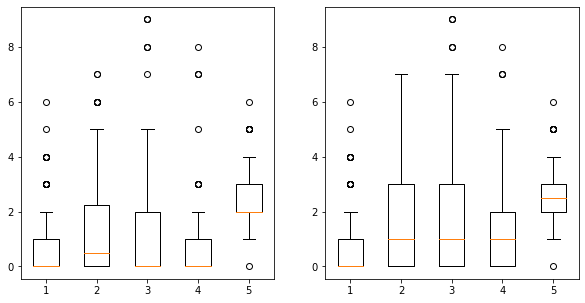

In [15]:
# Box plot of average identified model order across trajectory and model reps as a function of N
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].boxplot([np.nanargmin(scores[:, i, :, 0, :, 0].reshape(-1, 10), axis=1) for i in range(len(N))])
ax[1].boxplot([np.nanargmin(scores[:, i, :, 1, :, 0].reshape(-1, 10), axis=1) for i in range(len(N))])

In [ ]:
# Need to expand to more samples, still figure out wtf is going on with SVIC

In [ ]:
# Plot the delta ccm as a function of time lag

In [16]:
delta_ccm1.shape

(10, 5, 10, 4, 5)

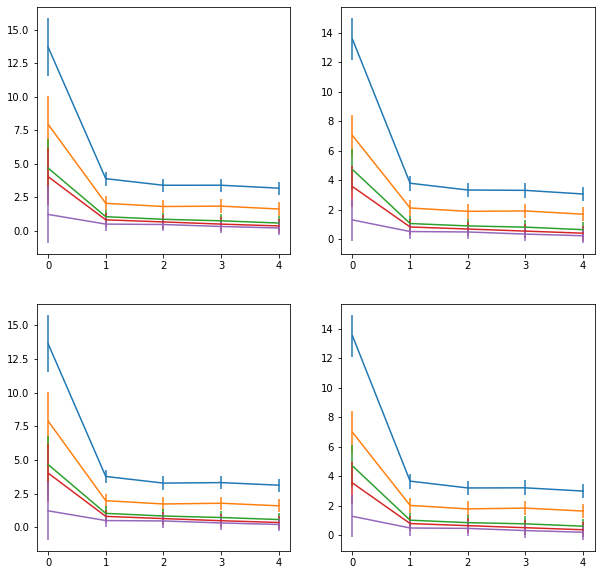

In [18]:
# Box plot of average identified model order across trajectory and model reps as a function of N
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for i in range(len(N)):
    ax[0, 0].errorbar(np.arange(5), np.mean(delta_ccm1[:, i, :, 0, :].reshape(-1, 5), axis=0), yerr=1/np.sqrt(50) * np.std(delta_ccm1[:, 1, :, 0, :].reshape(-1, 5), axis=0))
    ax[0, 1].errorbar(np.arange(5), np.mean(delta_ccm1[:, i, :, 1, :].reshape(-1, 5), axis=0), yerr=1/np.sqrt(50) * np.std(delta_ccm1[:, 1, :, 1, :].reshape(-1, 5), axis=0))

    ax[1, 0].errorbar(np.arange(5), np.mean(delta_ccm2[:, i, :, 0, :].reshape(-1, 5), axis=0), yerr=1/np.sqrt(50) * np.std(delta_ccm2[:, 1, :, 0, :].reshape(-1, 5), axis=0))
    ax[1, 1].errorbar(np.arange(5), np.mean(delta_ccm2[:, i, :, 1, :].reshape(-1, 5), axis=0), yerr=1/np.sqrt(50) * np.std(delta_ccm2[:, 1, :, 1, :].reshape(-1, 5), axis=0))

In [20]:
# Compare with VAR models. Note the large error in ccm[0] induced by the positive real correction

### CKMS Array Iteration for Stable Kalman Filtering

In [253]:
import pickle
with open('test_case.dat', 'rb') as f:
    varlist = pickle.load(f)

In [254]:
A, C, Cbar, L0 = varlist

In [255]:
from riccati import riccati_solve, check_gdare, discrete_generalized_riccati

In [267]:
# Compare Riccati iteration with the array algorithm

norm_diff = []
delta_norm_diff = []
norm_diff2 = []

reps = int(5e2)
P = np.zeros(A.shape)
Pinf = -1*scipy.linalg.solve_discrete_are(A.T, C.T, np.zeros(A.shape), L0, s=Cbar.T)

P0 = np.zeros(A.shape)
P = discrete_generalized_riccati(P0, A, C, Cbar, L0)
Re = L0 - C @ Pinf @ C.T
Resqrt = scipy.linalg.cholesky(L0 + C @ Pinf @ C.T)
K = (Cbar.T - A @ P @ C.T) @ np.linalg.pinv(Re)
eig, U = np.linalg.eig(P)
eig[eig < 1e-14] = 0
L = U @ scipy.linalg.sqrtm(np.diag(eig))
Psqrt = L

# Modified definitions due to generalized Riccati
F = A - Cbar.T @ np.linalg.pinv(L0) @ C
Q = np.zeros(A.shape) - Cbar.T @ np.linalg.pinv(L0) @ Cbar
Qsqrt = scipy.linalg.sqrtm(Q)

for i in range(reps):
    P0 = discrete_generalized_riccati(P, A, C, Cbar, L0)
    norm_diff.append(np.linalg.norm(P0 - Pinf))
    delta_norm_diff.append(np.linalg.norm())
    P = P0
    Psqrt = riccati_array(Psqrt, F, C, Qsqrt, Rsqrt)
    norm_diff2.append(np.linalg.norm(Psqrt @ Psqrt.T - Pinf))

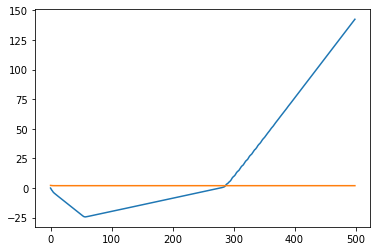

In [268]:
plt.plot(np.log(norm_diff))
plt.plot(np.log(norm_diff2))

In [138]:
from riccati import CKMS_Array, riccati_array

In [168]:
size = 20
obs_dim = 10
A = np.random.normal(scale= 1/(2 * np.sqrt(size)), size=(20, 20))
while max(np.abs(np.linalg.eigvals(A))) > 0.99:
    A = np.random.normal(scale= 1/(2 * np.sqrt(size)), size=(20, 20))

C = scipy.stats.ortho_group.rvs(size)[:, 0:obs_dim].T

In [169]:
ssr = SSR(A = A, B=np.eye(A.shape[0]), C=C)

In [170]:
error_riccati = lambda P: A @ P @ A.T + np.eye(P.shape[0]) - (A @ P @ C.T) @ np.linalg.pinv(ssr.cov + C @ P @ C.T) @ C @ P @ A.T

In [171]:
# Test whether the kalman gain obtained from iteating the CKMS_Array function coinncides with that obtained from asymptotic solution
Pinf = scipy.linalg.solve_discrete_are(A.T, C.T, np.eye(A.shape[0]), ssr.cov)
Kinf = (A @ Pinf @ C.T) @ np.linalg.pinv(ssr.cov + C @ Pinf @ C.T) 

In [193]:
knorm_diff1 = []
knorm_diff2 = []
pnormdiff1 = []
pnormdiff2 = []

# Need to step through one iteration before initializing the array algorithm
P0 = np.zeros(A.shape)
P = error_riccati(np.zeros(A.shape))
Re = ssr.cov + C @ P @ C.T
Resqrt = scipy.linalg.cholesky(Re)
K = A @ P @ C.T @ np.linalg.pinv(Re)
L = scipy.linalg.cholesky(P)
Psqrt = L

Qsqrt = scipy.linalg.cholesky(np.eye(A.shape[0]))
Rsqrt = scipy.linalg.cholesky(ssr.cov)

for i in range(200):
    Resqrt, K, L = CKMS_Array(Resqrt, K, L, A, C)    
    knorm_diff1.append(np.linalg.norm(K - Kinf))

    P = error_riccati(P)
    Kp = A @ P @ C.T @ np.linalg.pinv(ssr.cov + C @ P @ C.T)
    knorm_diff2.append(np.linalg.norm(Kp - Kinf))
    
    Psqrt = riccati_array(Psqrt, A, C, Qsqrt, Rsqrt)

    pnormdiff1.append(np.linalg.norm(P - Pinf))
    pnormdiff2.append(np.linalg.norm(Pinf - Psqrt @ Psqrt.T))


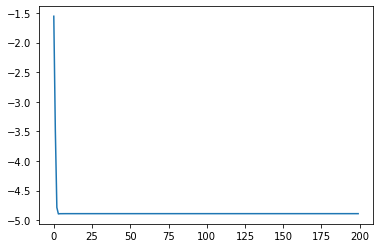

In [192]:
plt.plot(np.log(pnormdiff2))

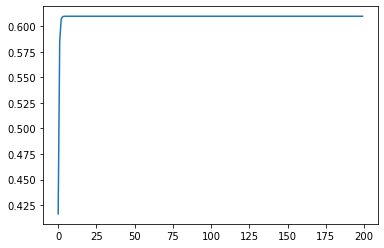

In [194]:
plt.plot(np.log(knorm_diff1))

In [174]:
np.log(np.linalg.norm(np.linalg.cholesky(Pinf) - Psqrt))

-5.41760144571039

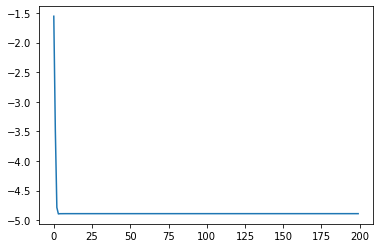

In [186]:
plt.plot(np.log(pnormdiff2))

In [202]:
eig, U = np.linalg.eig(P)

In [195]:
# CKMS Array not working, likely due to incorrect specification of L
# Need to now test on the generalized Riccati iterations

In [229]:
# Test whether the kalman gain obtained from iteating the CKMS_Array function coinncides with that obtained from asymptotic solution
Pinf = -1*scipy.linalg.solve_discrete_are(A.T, C.T, np.zeros(A.shape), ssr.cov, s=ssr.Cbar.T)
Kinf = (ssr.Cbar.T - A @ Pinf @ C.T) @ np.linalg.pinv(ssr.cov - C @ Pinf @ C.T)

In [246]:
knorm_diff1 = []
knorm_diff2 = []
pnormdiff1 = []
pnormdiff2 = []

# Need to step through one iteration before initializing the array algorithm
P0 = np.zeros(A.shape)
P = discrete_generalized_riccati(P0, A, C, ssr.Cbar, ssr.cov)

Re = ssr.cov - C @ Pinf @ C.T
Resqrt = scipy.linalg.cholesky(ssr.cov + C @ Pinf @ C.T)
K = (ssr.Cbar.T - A @ P @ C.T) @ np.linalg.pinv(Re)
eig, U = np.linalg.eig(P)
eig[eig < 1e-14] = 0
L = U @ scipy.linalg.sqrtm(np.diag(eig))
Psqrt = L

# Modified definitions due to generalized Riccati
Rsqrt = scipy.linalg.cholesky(ssr.cov)
F = A - ssr.Cbar.T @ np.linalg.pinv(ssr.cov) @ C
Q = np.zeros(A.shape) - ssr.Cbar.T @ np.linalg.pinv(ssr.cov) @ ssr.Cbar
Qsqrt = scipy.linalg.sqrtm(Q)

for i in range(200):
    Resqrt, K, L = CKMS_Array(Resqrt, K, L, F, C)    
    knorm_diff1.append(np.linalg.norm(K - Kinf))

    P = discrete_generalized_riccati(P, A, C, ssr.Cbar, ssr.cov)

    Kp = (ssr.Cbar.T - A @ P @ C.T) @ np.linalg.pinv(Re)
    knorm_diff2.append(np.linalg.norm(Kp - Kinf))
    
    Psqrt = riccati_array(Psqrt, F, C, Qsqrt, Rsqrt)

    pnormdiff1.append(np.linalg.norm(P - Pinf))
    pnormdiff2.append(np.linalg.norm(Pinf - Psqrt @ Psqrt.T))


In [250]:
Psqrt @ Psqrt.T

array([[ 1.23547176e-01+0.00000000e+00j, -2.20606128e-02-8.72329421e-19j,
        -2.47287163e-02-4.54055868e-20j,  3.94064996e-05-6.30845041e-19j,
        -3.14537530e-02-1.82281408e-18j, -7.06464441e-03-1.41080820e-18j,
         1.71486651e-02-2.34509829e-19j, -1.59541988e-02+2.18878280e-18j,
        -4.59676958e-02-1.53975118e-18j, -1.21691617e-02+5.17183952e-21j,
        -8.83617919e-02+2.57588114e-19j,  7.39869230e-02-1.20516174e-18j,
         5.96759170e-02-3.36664766e-19j, -6.94910669e-03+3.09281712e-20j,
         1.71982614e-02-2.13335791e-18j, -3.00605865e-02+2.36776697e-19j,
        -2.93896151e-02-1.51527552e-18j, -4.94519453e-02+1.65633459e-18j,
        -4.37053326e-02-9.13964648e-19j,  1.59622968e-02+7.72554229e-19j],
       [-2.20606128e-02-8.72329421e-19j,  4.67123566e-02+3.11526692e-19j,
        -8.90955660e-03+1.85205555e-18j, -1.03077516e-02+1.03585319e-18j,
        -1.42172709e-03-8.03964154e-20j,  1.59770442e-03-5.11363506e-19j,
         6.00987337e-03+2.45929468e-2

In [249]:
Pinf

array([[ 0.1268327 , -0.02257037, -0.02600542, -0.00192113, -0.03238214,
        -0.00958785,  0.01785932, -0.01886241, -0.04500984, -0.01262183,
        -0.08901965,  0.07578467,  0.05896754, -0.00722554,  0.01822905,
        -0.03173243, -0.02753793, -0.05062623, -0.04023674,  0.01506829],
       [-0.02257037,  0.04870522, -0.0091871 , -0.01039961, -0.00099888,
         0.00237215,  0.00618051,  0.01608335,  0.02980098, -0.03027873,
         0.0302878 , -0.0097501 , -0.00261258, -0.0324583 , -0.01390902,
         0.01219176,  0.0089909 ,  0.03287433,  0.03284543, -0.01040576],
       [-0.02600542, -0.0091871 ,  0.08546744, -0.03270608,  0.02133652,
         0.08590781,  0.03583294, -0.00739221,  0.00219666,  0.04283642,
         0.0037059 , -0.01144176,  0.05709026, -0.01275132, -0.07913043,
         0.00749039,  0.02022101, -0.00081039, -0.01424149,  0.02679003],
       [-0.00192113, -0.01039961, -0.03270608,  0.12864384, -0.01465945,
        -0.02648639, -0.04111019,  0.02286711,  

In [247]:
np.linalg.norm(Pinf - anp.real(Psqrt) @ np.real(Psqrt).T)

0.026042481733964024

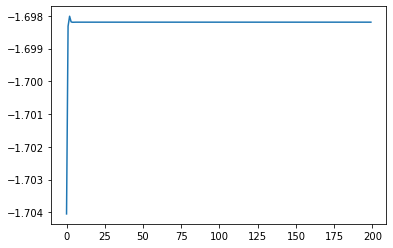

In [248]:
plt.plot(np.log(knorm_diff1))

In [127]:
# Test accuracy of recovery of autocorrelations in forward and reverse directions 
reps = 10
N = np.array([1e3, 5e3, 1e4, 5e4, 1e5, 5e5, 1e6]).astype(int)

delta_true = np.zeros((reps, N.size, 4, 5))
delta_emp = np.zeros((reps, N.size, 4, 5))

for i in tqdm.tqdm(range(reps)):

    size = 20
    A = np.random.normal(scale=1/(2 * np.sqrt(size)), size=(size, size))

    while max(np.abs(np.linalg.eigvals(A))) > 0.99:
        A = np.random.normal(scale=1/(2 * np.sqrt(size)), size=(size, size))

    C = scipy.stats.ortho_group.rvs(size)[:, 0:2].T
    ssr = SSR(A=A, B=np.eye(A.shape[0]), C=np.eye(A.shape[0]))
    ccm0 = ssr.autocorrelation(10)
    for j, n in tqdm.tqdm(enumerate(N)):
        y = ssr.trajectory(n)
        ccm = estimate_autocorrelation(y, 10)

        # Note that the same time autocorrelation in SSID is 
        # automatically reproduced through the choice of D

        A_, C, Cbar, AA, AAt, CC, CCbar = subspace_identification(y, ccm, 4, 20)
        ccm1 = np.array([C @ np.linalg.matrix_power(A, i - 1) @ Cbar.T for i in range(1, 6)])
        ccm2 = np.array([CC @ np.linalg.matrix_power(AA, i - 1) @ CCbar.T for i in range(1, 6)])

        delta_true[i, j, 0, :] = [np.linalg.norm(ccm0[j + 1] - ccm1[j]) for j in range(5)]
        delta_true[i, j, 1, :] = [np.linalg.norm(ccm0[j + 1] - ccm2[j]) for j in range(5)]

        delta_emp[i, j, 0, :] = [np.linalg.norm(ccm[j + 1] - ccm1[j]) for j in range(5)]
        delta_true[i, j, 1, :] = [np.linalg.norm(ccm[j + 1] - ccm1[j]) for j in range(5)]

        # Benchmark against VAR(1), VAR(3) model
        var1model = VAR(estimator='ols', order=1)
        var1model.fit(y)
        varss = VARss(var1model.coef_)
        ccmvar = varss.autocorrelation(6)
        delta_true[i, j, 2, :] = [np.linalg.norm(ccm0[j + 1] - ccmvar[j]) for j in range(5)]
        delta_emp[i, j, 2, :] = [np.linalg.norm(ccm[j + 1] - ccmvar[j]) for j in range(5)]

        var3model = VAR(estimator='ols', order=3)
        var3model.fit(y)
        varss = VARss(var3model.coef_)
        ccmvar = varss.autocorrelation(6)
        delta_true[i, j, 2, :] = [np.linalg.norm(ccm0[j + 1] - ccmvar[j]) for j in range(5)]
        delta_emp[i, j, 2, :] = [np.linalg.norm(ccm[j + 1] - ccmvar[j]) for j in range(5)]
    

0it [00:00, ?it/s]
  0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'subspace_identification' is not defined

In [77]:
selected_data_files = data_files[0:4]
subspace_angles = []
loadings_correlations = []
dca_subspace_angles = []

for i, data_file in enumerate(selected_data_files):
    dat = load_sabes(data_file, **sabes_args.loader_args[0])
    X = np.squeeze(dat['spike_rates'])
    X -= np.mean(X, axis=0)

    # No regularization
    ccm = calc_cross_cov_mats_from_data(X, 11)
    orders = np.arange(X.shape[-1]//2, 3 * X.shape[-1], 10)

    pcamodel = PCA().fit(X)
    pca_U = pcamodel.components_.T[:, 0:2]

    # dcamodel = DCA(d=2, T=3)
    # dcamodel.estimate_data_statistics(X)
    # # Keep track of DCA projection 
    # dca_coef = []
    # for k in range(10):
    #     coef_, _ = dcamodel._fit_projection()
    #     dca_coef.append(coef_)

    subspace_angles_ = np.zeros(orders.size)
    loadings_correlations_ = np.zeros(orders.size)
    autocorrelation_error_norm = np.zeros(orders.size)

    # dca_subspace_angles_ = np.zeros(orders.size)

    for j, order in tqdm.tqdm(enumerate(orders)):
        A, B, C, D, Cbar = subspace_identification(ccm, order)
        ssr = SSR(A=A, B=B, C=C, D=D)
        eigvals, model_U = np.linalg.eig(ssr.cov)

        eigorder = np.argsort(eigvals)[::-1]
        model_U = model_U[:, eigorder]

        subspace_angles_[j] = np.linalg.norm(scipy.linalg.subspace_angles(pca_U, model_U))
        loadings_correlations_[j] = scipy.stats.spearmanr(calc_loadings(pca_U), calc_loadings(model_U))[0]

        ssr_ccm = ssr.autocorrelation(11)
        dcamodel.cross_covs = ccm

        model_dca_coef = []
        for k in range(10):
            coef_, _ = dcamodel._fit_projection()
            model_dca_coef.append(coef_)


        dca_ss = np.zeros((10, 10))
        for k1 in range(10):
            for k2 in range(10):
                dca_ss[k1, k2] = np.linalg.norm(scipy.linalg.subspace_angles(dca_coef[k1], model_dca_coef[k2]))

        dca_subspace_angles_[j] = np.min(dca_ss)

    dca_subspace_angles.append(dca_subspace_angles_)
    subspace_angles.append(subspace_angles_)
    loadings_correlations.append(loadings_correlations_)     

In [42]:
from dca_research.kca import KalmanComponentsAnalysis as KCA

In [43]:
# Do PCA and KCA coincide for A symmetric, but B random??

In [88]:
A = np.diag(np.random.uniform(0, 0.99, size=(10,)))
T = scipy.stats.ortho_group.rvs(10)
A = T @ A @ T.T
# B should be obtained from the cholesky decomposition of a psd matrix
Q = np.diag(np.random.uniform(0, 2, size=(10,)))
T = scipy.stats.ortho_group.rvs(10)
Q = T @ Q @ T.T
B = np.linalg.cholesky(Q)

In [104]:
ssr = SSR(A=A, B=B, C=np.eye(A.shape[0]))

In [105]:
x = ssr.trajectory(int(1e5))

In [106]:
kcamodel = KCA(T=1, d=2, n_init=5)
kcamodel.fit(x)

In [107]:
eig, U = np.linalg.eig(ssr.P)
eigorder = np.argsort(np.abs(eig))[::-1]
U = U[:, eigorder]

In [108]:
scipy.linalg.subspace_angles(kcamodel.coef_, U[:, 0:2])

array([0.16249198, 0.03812075])

In [109]:
# Seems like the ss angles are non-negligible, but not large like we can get with non-normal matrices. Can we quantify this?